In [2]:
!conda install -c conda-forge fbprophet -y

Solving environment: ...working... done

# All requested packages already installed.



In [3]:
!pip install --upgrade plotly

Requirement already up-to-date: plotly in c:\users\bviei\anaconda3\lib\site-packages (4.14.3)


In [4]:
!pip install fbprophet

In [5]:
import pandas as pd
import numpy as np
from numpy import sqrt
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import lag_plot
!pip install pmdarima

import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [6]:
brent = pd.read_csv("brent.csv", usecols=[0,1,2,3,4,5,6], decimal=",")
wti = pd.read_csv('wti.csv', usecols=[0,1,2,3,4,5,6], decimal=",")

In [7]:
brent

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,31.12.2019,66.00,66.65,66.93,65.63,"171,01K","-3,57%"
1,30.12.2019,68.44,68.20,68.99,68.16,"29,42K","0,41%"
2,27.12.2019,68.16,67.91,68.33,67.57,"112,22K","0,35%"
3,26.12.2019,67.92,67.27,67.99,67.22,"69,82K","1,07%"
4,24.12.2019,67.20,66.44,67.26,66.36,"104,94K","1,22%"
...,...,...,...,...,...,...,...
2576,08.01.2010,81.37,81.51,82.05,80.59,"157,49K","-0,17%"
2577,07.01.2010,81.51,82.00,82.05,81.05,"131,28K","-0,46%"
2578,06.01.2010,81.89,80.38,82.21,79.77,"157,87K","1,61%"
2579,05.01.2010,80.59,80.29,80.84,79.75,"131,75K","0,59%"


In [8]:
wti

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,31.12.2019,61.06,61.68,61.88,60.63,"494,54K","-1,01%"
1,30.12.2019,61.68,61.71,62.34,61.09,"427,15K","-0,06%"
2,27.12.2019,61.72,61.73,61.97,61.24,"351,90K","0,06%"
3,26.12.2019,61.68,61.20,61.83,61.06,"265,09K","0,80%"
4,25.12.2019,61.19,61.45,61.52,61.17,-,"0,13%"
...,...,...,...,...,...,...,...
2586,08.01.2010,82.75,82.65,83.47,81.80,"310,38K","0,11%"
2587,07.01.2010,82.66,83.20,83.36,82.26,"246,63K","-0,63%"
2588,06.01.2010,83.18,81.43,83.52,80.85,"370,06K","1,72%"
2589,05.01.2010,81.77,81.63,82.00,80.95,"258,89K","0,32%"


In [9]:
#DATAS - adequa as datas e também as define como index (o que facilitará a indentificação como eixo x nos gráficos)

brent['Data'] = pd.to_datetime(brent['Data'], format='%d.%m.%Y')
wti['Data'] = pd.to_datetime(wti['Data'], format='%d.%m.%Y')



brent.index = pd.to_datetime(brent.Data, format='%d.%m.%Y')
wti.index = pd.to_datetime(wti.Data, format='%d.%m.%Y')

brent.index.to_period('D')
wti.index.to_period('D')

PeriodIndex(['2019-12-31', '2019-12-30', '2019-12-27', '2019-12-26',
             '2019-12-25', '2019-12-24', '2019-12-23', '2019-12-20',
             '2019-12-19', '2019-12-18',
             ...
             '2010-01-15', '2010-01-14', '2010-01-13', '2010-01-12',
             '2010-01-11', '2010-01-08', '2010-01-07', '2010-01-06',
             '2010-01-05', '2010-01-04'],
            dtype='period[D]', name='Data', length=2591, freq='D')

In [10]:
#CAMPOS COM VALORES - ajuste nos números e também no campo volume, que cotinha letras indicando as ordens de mil, milhão e bilhão
brent["Abertura"] = brent["Abertura"].astype(str)
brent["Último"] = brent["Último"].astype(str)
brent["Máxima"] = brent["Máxima"].astype(str)
brent["Mínima"] = brent["Mínima"].astype(str)
brent["Var%"] = brent["Var%"].astype(str)
brent["Vol."] = brent["Vol."].astype(str)

brent["Abertura"]=pd.Series(brent["Abertura"]).str.replace(',', '.', regex=True)
brent["Último"]=pd.Series(brent["Último"]).str.replace(',', '.', regex=True)
brent["Máxima"]=pd.Series(brent["Máxima"]).str.replace(',', '.', regex=True)
brent["Mínima"]=pd.Series(brent["Mínima"]).str.replace(',', '.', regex=True)
brent["Var%"]=pd.Series(brent["Var%"]).str.replace(',', '.', regex=True)
brent["Var%"]=pd.Series(brent["Var%"]).str.replace('%', '', regex=True)
brent["Vol."]=pd.Series(brent["Vol."]).str.replace('-', '', regex=True)
brent["Vol."]=pd.Series(brent["Vol."]).str.replace(',', '', regex=True)
brent["Vol."]=pd.Series(brent["Vol."]).str.replace('M',"000000", regex=True)
brent["Vol."]=pd.Series(brent["Vol."]).str.replace('K',"000", regex=True)
brent["Vol."]=pd.Series(brent["Vol."]).str.replace('B',"000000000", regex=True)

brent["Abertura"] = pd.to_numeric(brent["Abertura"])
brent["Último"] = pd.to_numeric(brent["Último"])
brent["Máxima"] = pd.to_numeric(brent["Máxima"])
brent["Mínima"] = pd.to_numeric(brent["Mínima"])
brent["Var%"] = pd.to_numeric(brent["Var%"])
brent["Vol."] = pd.to_numeric(brent["Vol."])

In [11]:
#CAMPOS COM VALORES - ajuste nos números e também no campo volume, que cotinha letras indicando as ordens de mil, milhão e bilhão
wti["Abertura"] = wti["Abertura"].astype(str)
wti["Último"] = wti["Último"].astype(str)
wti["Máxima"] = wti["Máxima"].astype(str)
wti["Mínima"] = wti["Mínima"].astype(str)
wti["Var%"] = wti["Var%"].astype(str)
wti["Vol."] = wti["Vol."].astype(str)

wti["Abertura"]=pd.Series(wti["Abertura"]).str.replace(',', '.', regex=True)
wti["Último"]=pd.Series(wti["Último"]).str.replace(',', '.', regex=True)
wti["Máxima"]=pd.Series(wti["Máxima"]).str.replace(',', '.', regex=True)
wti["Mínima"]=pd.Series(wti["Mínima"]).str.replace(',', '.', regex=True)
wti["Var%"]=pd.Series(wti["Var%"]).str.replace(',', '.', regex=True)
wti["Var%"]=pd.Series(wti["Var%"]).str.replace('%', '', regex=True)
wti["Vol."]=pd.Series(wti["Vol."]).str.replace('-', '', regex=True)
wti["Vol."]=pd.Series(wti["Vol."]).str.replace(',', '', regex=True)
wti["Vol."]=pd.Series(wti["Vol."]).str.replace('M',"000000", regex=True)
wti["Vol."]=pd.Series(wti["Vol."]).str.replace('K',"000", regex=True)
wti["Vol."]=pd.Series(wti["Vol."]).str.replace('B',"000000000", regex=True)

wti["Abertura"] = pd.to_numeric(wti["Abertura"])
wti["Último"] = pd.to_numeric(wti["Último"])
wti["Máxima"] = pd.to_numeric(wti["Máxima"])
wti["Mínima"] = pd.to_numeric(wti["Mínima"])
wti["Var%"] = pd.to_numeric(wti["Var%"])
wti["Vol."] = pd.to_numeric(wti["Vol."])

In [12]:
brent

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,,
2019-12-31,2019-12-31,66.00,66.65,66.93,65.63,17101000.0,-3.57
2019-12-30,2019-12-30,68.44,68.20,68.99,68.16,2942000.0,0.41
2019-12-27,2019-12-27,68.16,67.91,68.33,67.57,11222000.0,0.35
2019-12-26,2019-12-26,67.92,67.27,67.99,67.22,6982000.0,1.07
2019-12-24,2019-12-24,67.20,66.44,67.26,66.36,10494000.0,1.22
...,...,...,...,...,...,...,...
2010-01-08,2010-01-08,81.37,81.51,82.05,80.59,15749000.0,-0.17
2010-01-07,2010-01-07,81.51,82.00,82.05,81.05,13128000.0,-0.46
2010-01-06,2010-01-06,81.89,80.38,82.21,79.77,15787000.0,1.61


In [13]:
wti

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,,
2019-12-31,2019-12-31,61.06,61.68,61.88,60.63,49454000.0,-1.01
2019-12-30,2019-12-30,61.68,61.71,62.34,61.09,42715000.0,-0.06
2019-12-27,2019-12-27,61.72,61.73,61.97,61.24,35190000.0,0.06
2019-12-26,2019-12-26,61.68,61.20,61.83,61.06,26509000.0,0.80
2019-12-25,2019-12-25,61.19,61.45,61.52,61.17,NaN,0.13
...,...,...,...,...,...,...,...
2010-01-08,2010-01-08,82.75,82.65,83.47,81.80,31038000.0,0.11
2010-01-07,2010-01-07,82.66,83.20,83.36,82.26,24663000.0,-0.63
2010-01-06,2010-01-06,83.18,81.43,83.52,80.85,37006000.0,1.72


In [14]:
brent.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [15]:
wti.isnull().sum()

Data         0
Último       0
Abertura     0
Máxima       0
Mínima       0
Vol.        74
Var%         0
dtype: int64

In [16]:
brent_medianaMA = brent["Máxima"].rolling(5).mean().shift(-5).round(0)
brent_medianaMI = brent["Mínima"].rolling(5).mean().shift(-5).round(0)
brent_medianaAB = brent["Abertura"].rolling(5).mean().shift(-5).round(0)
brent_medianaUL = brent["Último"].rolling(5).mean().shift(-5).round(0)
brent_medianaVOL = brent["Vol."].rolling(5).mean().shift(-5).round(0)
brent["Máxima"].fillna(brent_medianaMA, inplace=True)
brent["Mínima"].fillna(brent_medianaMI, inplace=True)
brent["Abertura"].fillna(brent_medianaAB, inplace=True)
brent["Último"].fillna(brent_medianaUL, inplace=True)
brent["Vol."].fillna(brent_medianaVOL, inplace=True)

In [17]:
wti_medianaMA = wti["Máxima"].rolling(5).mean().shift(-5).round(0)
wti_medianaMI = wti["Mínima"].rolling(5).mean().shift(-5).round(0)
wti_medianaAB = wti["Abertura"].rolling(5).mean().shift(-5).round(0)
wti_medianaUL = wti["Último"].rolling(5).mean().shift(-5).round(0)
wti_medianaVOL = wti["Vol."].rolling(5).mean().shift(-5).round(0)
wti["Máxima"].fillna(wti_medianaMA, inplace=True)
wti["Mínima"].fillna(wti_medianaMI, inplace=True)
wti["Abertura"].fillna(wti_medianaAB, inplace=True)
wti["Último"].fillna(wti_medianaUL, inplace=True)
wti["Vol."].fillna(wti_medianaVOL, inplace=True)

In [18]:
brent.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [19]:
wti.isnull().sum()

Data         0
Último       0
Abertura     0
Máxima       0
Mínima       0
Vol.        27
Var%         0
dtype: int64

In [20]:
wti_medianaVOL = wti["Vol."].rolling(5).mean().shift(-5).round(0)
wti["Vol."].fillna(wti_medianaVOL, inplace=True)

In [21]:
wti.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

In [22]:
wti_medianaVOL = wti["Vol."].rolling(5).mean().shift(-5).round(0)
wti["Vol."].fillna(wti_medianaVOL, inplace=True)

In [23]:
wti.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

In [24]:
#JUNÇÃO DAS TABELAS, cria dataset bw

brent.rename(columns= {'Data': 'data'}, inplace=True)
wti.rename(columns= {'Data': 'data'}, inplace=True)

bw = pd.merge(brent,wti,how='inner', on=['data'],suffixes=('_B', '_W'))

In [25]:
bw.isnull().sum()

data          0
Último_B      0
Abertura_B    0
Máxima_B      0
Mínima_B      0
Vol._B        0
Var%_B        0
Último_W      0
Abertura_W    0
Máxima_W      0
Mínima_W      0
Vol._W        0
Var%_W        0
dtype: int64

In [26]:
bw

,data,Último_B,Abertura_B,Máxima_B,Mínima_B,Vol._B,Var%_B,Último_W,Abertura_W,Máxima_W,Mínima_W,Vol._W,Var%_W
0,2019-12-31,66.00,66.65,66.93,65.63,17101000.0,-3.57,61.06,61.68,61.88,60.63,49454000.0,-1.01
1,2019-12-30,68.44,68.20,68.99,68.16,2942000.0,0.41,61.68,61.71,62.34,61.09,42715000.0,-0.06
2,2019-12-27,68.16,67.91,68.33,67.57,11222000.0,0.35,61.72,61.73,61.97,61.24,35190000.0,0.06
3,2019-12-26,67.92,67.27,67.99,67.22,6982000.0,1.07,61.68,61.20,61.83,61.06,26509000.0,0.80
4,2019-12-24,67.20,66.44,67.26,66.36,10494000.0,1.22,61.11,60.63,61.16,60.47,20454000.0,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2555,2010-01-08,81.37,81.51,82.05,80.59,15749000.0,-0.17,82.75,82.65,83.47,81.80,31038000.0,0.11
2556,2010-01-07,81.51,82.00,82.05,81.05,13128000.0,-0.46,82.66,83.20,83.36,82.26,24663000.0,-0.63
2557,2010-01-06,81.89,80.38,82.21,79.77,15787000.0,1.61,83.18,81.43,83.52,80.85,37006000.0,1.72
2558,2010-01-05,80.59,80.29,80.84,79.75,13175000.0,0.59,81.77,81.63,82.00,80.95,25889000.0,0.32


In [27]:
bw.index = pd.to_datetime(bw.data, format='%d.%m.%Y')

In [28]:
bw

,data,Último_B,Abertura_B,Máxima_B,Mínima_B,Vol._B,Var%_B,Último_W,Abertura_W,Máxima_W,Mínima_W,Vol._W,Var%_W
data,,,,,,,,,,,,,
2019-12-31,2019-12-31,66.00,66.65,66.93,65.63,17101000.0,-3.57,61.06,61.68,61.88,60.63,49454000.0,-1.01
2019-12-30,2019-12-30,68.44,68.20,68.99,68.16,2942000.0,0.41,61.68,61.71,62.34,61.09,42715000.0,-0.06
2019-12-27,2019-12-27,68.16,67.91,68.33,67.57,11222000.0,0.35,61.72,61.73,61.97,61.24,35190000.0,0.06
2019-12-26,2019-12-26,67.92,67.27,67.99,67.22,6982000.0,1.07,61.68,61.20,61.83,61.06,26509000.0,0.80
2019-12-24,2019-12-24,67.20,66.44,67.26,66.36,10494000.0,1.22,61.11,60.63,61.16,60.47,20454000.0,0.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-08,2010-01-08,81.37,81.51,82.05,80.59,15749000.0,-0.17,82.75,82.65,83.47,81.80,31038000.0,0.11
2010-01-07,2010-01-07,81.51,82.00,82.05,81.05,13128000.0,-0.46,82.66,83.20,83.36,82.26,24663000.0,-0.63
2010-01-06,2010-01-06,81.89,80.38,82.21,79.77,15787000.0,1.61,83.18,81.43,83.52,80.85,37006000.0,1.72


In [29]:
brent1 = pd.DataFrame(columns={"data","Abertura_B", "Máxima_B", "Mínima_B","Último_B", "Vol._B"}).copy()
brent1["data"]= bw["data"]
brent1["Abertura_B"]= bw["Abertura_B"]
brent1["Máxima_B"]= bw["Máxima_B"]
brent1["Mínima_B"]= bw["Mínima_B"]
brent1["Último_B"]= bw["Último_B"]
brent1["Vol._B"]= bw["Vol._B"]

In [30]:
brent1

,Abertura_B,Último_B,Máxima_B,data,Vol._B,Mínima_B
data,,,,,,
2019-12-31,66.65,66.00,66.93,2019-12-31,17101000.0,65.63
2019-12-30,68.20,68.44,68.99,2019-12-30,2942000.0,68.16
2019-12-27,67.91,68.16,68.33,2019-12-27,11222000.0,67.57
2019-12-26,67.27,67.92,67.99,2019-12-26,6982000.0,67.22
2019-12-24,66.44,67.20,67.26,2019-12-24,10494000.0,66.36
...,...,...,...,...,...,...
2010-01-08,81.51,81.37,82.05,2010-01-08,15749000.0,80.59
2010-01-07,82.00,81.51,82.05,2010-01-07,13128000.0,81.05
2010-01-06,80.38,81.89,82.21,2010-01-06,15787000.0,79.77


In [31]:
wti1 = pd.DataFrame(columns={"data","Abertura_W", "Máxima_W", "Mínima_W","Último_W", "Vol._W"}).copy()
wti1["data"]= bw["data"]
wti1["Abertura_W"]= bw["Abertura_W"]
wti1["Máxima_W"]= bw["Máxima_W"]
wti1["Mínima_W"]= bw["Mínima_W"]
wti1["Último_W"]= bw["Último_W"]
wti1["Vol._W"]= bw["Vol._W"]

In [32]:
wti1

,Mínima_W,data,Abertura_W,Vol._W,Máxima_W,Último_W
data,,,,,,
2019-12-31,60.63,2019-12-31,61.68,49454000.0,61.88,61.06
2019-12-30,61.09,2019-12-30,61.71,42715000.0,62.34,61.68
2019-12-27,61.24,2019-12-27,61.73,35190000.0,61.97,61.72
2019-12-26,61.06,2019-12-26,61.20,26509000.0,61.83,61.68
2019-12-24,60.47,2019-12-24,60.63,20454000.0,61.16,61.11
...,...,...,...,...,...,...
2010-01-08,81.80,2010-01-08,82.65,31038000.0,83.47,82.75
2010-01-07,82.26,2010-01-07,83.20,24663000.0,83.36,82.66
2010-01-06,80.85,2010-01-06,81.43,37006000.0,83.52,83.18


In [33]:
brent1.rename(columns= {'data': 'Data'}, inplace=True)
wti1.rename(columns= {'data': 'Data'}, inplace=True)

In [34]:
brent1

,Abertura_B,Último_B,Máxima_B,Data,Vol._B,Mínima_B
data,,,,,,
2019-12-31,66.65,66.00,66.93,2019-12-31,17101000.0,65.63
2019-12-30,68.20,68.44,68.99,2019-12-30,2942000.0,68.16
2019-12-27,67.91,68.16,68.33,2019-12-27,11222000.0,67.57
2019-12-26,67.27,67.92,67.99,2019-12-26,6982000.0,67.22
2019-12-24,66.44,67.20,67.26,2019-12-24,10494000.0,66.36
...,...,...,...,...,...,...
2010-01-08,81.51,81.37,82.05,2010-01-08,15749000.0,80.59
2010-01-07,82.00,81.51,82.05,2010-01-07,13128000.0,81.05
2010-01-06,80.38,81.89,82.21,2010-01-06,15787000.0,79.77


In [35]:
#Serparar treino e teste

filtroB  = brent1['Data']<= "2016-12-31"
train_B = brent1[filtroB]

filtroW  = wti1['Data']<= "2016-12-31"
train_W = wti1[filtroW]

filtroBteste  = brent1['Data']> "2016-12-31"
teste_B = brent1[filtroBteste]

filtroWteste  = wti1['Data']> "2016-12-31"
teste_W = wti1[filtroWteste]

In [36]:
#correlação

train_B["Último_B"].corr(train_W["Último_W"])

0.9745391323161525

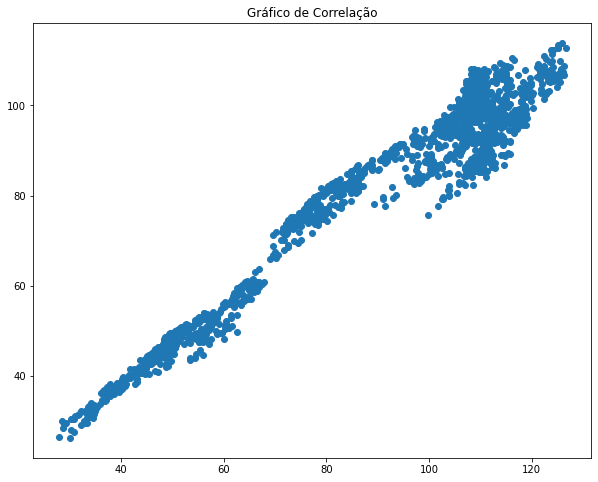

In [37]:
data1=train_B["Último_B"]
data2=train_W["Último_W"]

plt.scatter(data1, data2)
plt.title('Gráfico de Correlação')
plt.gcf().set_size_inches(10, 8)
plt.show()

#diretamente proporcionais com alta correlação

In [38]:


eixo_x = train_B['Data']
linha_brent1_ultimo = train_B["Último_B"]
linha_wti1_ultimo = train_W["Último_W"]
trace1 = go.Scatter(x = eixo_x,y = linha_brent1_ultimo,mode = 'lines', name = 'BRENT')
trace2 = go.Scatter(x = eixo_x,y = linha_wti1_ultimo,mode = 'lines',name = 'WTI')
data = [trace1, trace2]
py.iplot(data)

In [39]:
train_B.describe()

,Abertura_B,Último_B,Máxima_B,Vol._B,Mínima_B
count,1787.000000,1787.000000,1787.000000,1.787000e+03,1787.000000
mean,86.967857,86.978215,87.963212,1.943510e+07,85.900235
std,27.278378,27.329470,27.340258,7.398364e+06,27.210115
min,27.990000,27.880000,28.750000,1.152000e+06,27.100000
25%,59.580000,59.230000,60.560000,1.535850e+07,58.375000
50%,99.540000,99.650000,100.620000,1.950300e+07,97.920000
75%,109.760000,109.885000,110.800000,2.356550e+07,108.900000
max,126.580000,126.650000,128.400000,4.638100e+07,125.000000


In [40]:
import plotly.graph_objects as go  



fig = go.Figure(data=[go.Candlestick(x=train_B['Data'],
                open=train_B['Abertura_B'], high=train_B['Máxima_B'],
                low=train_B['Mínima_B'], close=train_B["Último_B"])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)  
fig.show()

Text(0.5, 1.0, 'Distribuição de Fechamento - BRENT')

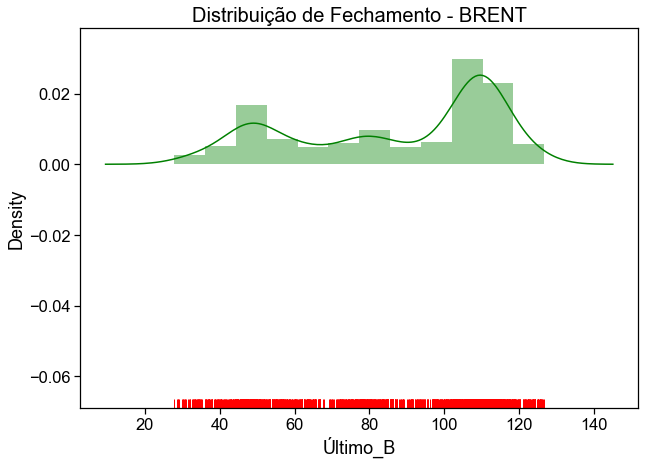

In [41]:
import seaborn as sns
plt.figure(figsize=(10,7))
sns.set_context("notebook", font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(train_B["Último_B"], color ='red')
sns.distplot(train_B["Último_B"], color ='green')
sns.set_style("darkgrid")
plt.title("Distribuição de Fechamento - BRENT")

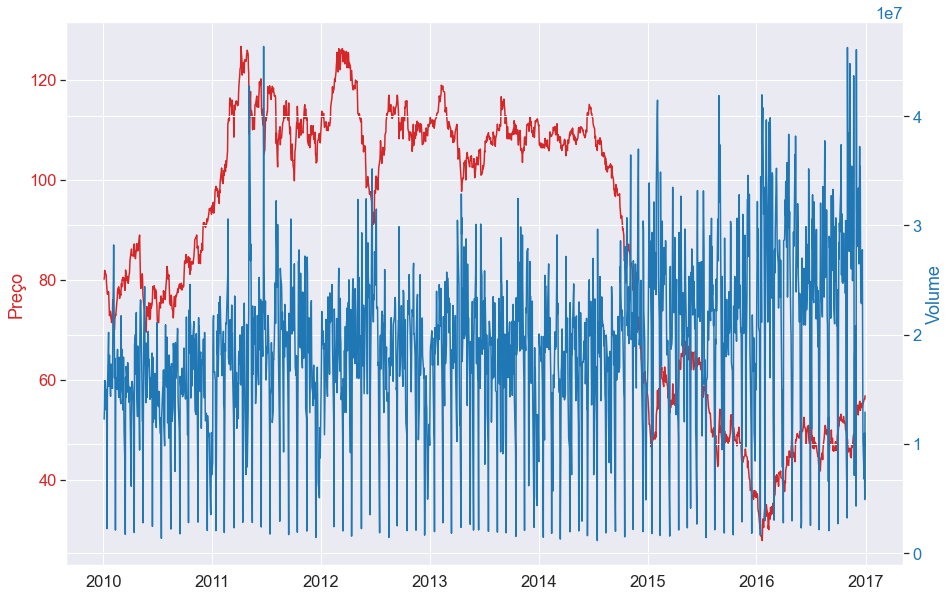

In [42]:
#gráfico com dois eixos y

b = train_B["Data"]
data1 = train_B["Último_B"]
data2 = train_B["Vol._B"]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Preço', color=color)
ax1.plot(b, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Volume', color=color)  
ax2.plot(b, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.gcf().set_size_inches(15, 10)
plt.show()

In [43]:
train_W.describe()

,Mínima_W,Abertura_W,Vol._W,Máxima_W,Último_W
count,1787.000000,1787.000000,1.787000e+03,1787.000000,1787.000000
mean,77.664057,78.779239,3.200921e+07,79.767185,78.753643
std,22.891260,22.954251,1.581953e+07,22.972323,22.978843
min,26.050000,27.300000,2.210000e+06,27.480000,26.210000
25%,52.055000,53.045000,2.244200e+07,54.005000,53.000000
50%,85.550000,86.570000,2.941880e+07,87.770000,86.670000
75%,96.260000,97.310000,3.937150e+07,98.065000,97.330000
max,112.250000,113.890000,1.310000e+08,114.830000,113.930000


Text(0.5, 1.0, 'Distribuição de Fechamento - WTI')

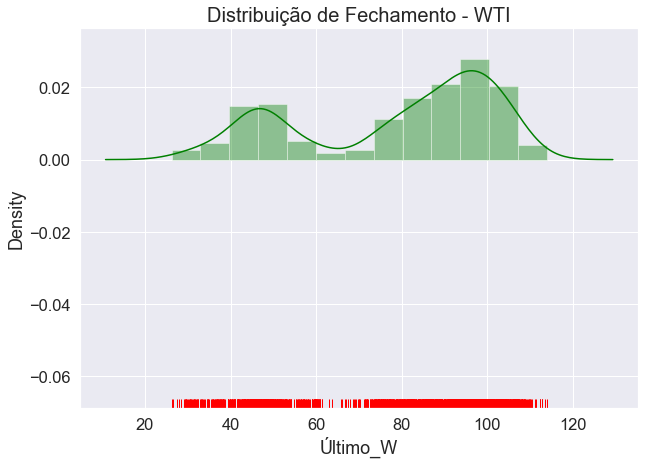

In [44]:
plt.figure(figsize=(10,7))
sns.set_context("notebook", font_scale=1.5, rc={'font.size':20, 'axes.titlesize':20, 'axes.labelsize':18})
sns.rugplot(train_W["Último_W"], color ='red')
sns.distplot(train_W["Último_W"], color ='green')
sns.set_style("darkgrid")
plt.title("Distribuição de Fechamento - WTI")

In [45]:
import plotly.graph_objects as go  



fig = go.Figure(data=[go.Candlestick(x=train_W['Data'],
                open=train_W['Abertura_W'], high=train_W['Máxima_W'],
                low=train_W['Mínima_W'], close=train_W["Último_W"])
                     ])

fig.update_layout(xaxis_rangeslider_visible=False)  
fig.show()

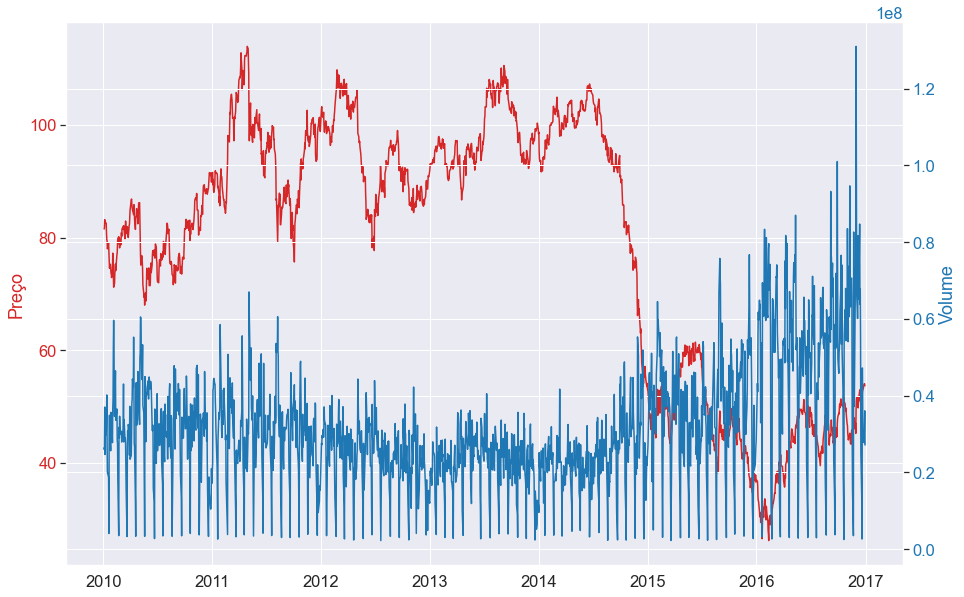

In [46]:
w = train_W["Data"]
data1 = train_W["Último_W"]
data2 = train_W["Vol._W"]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('')
ax1.set_ylabel('Preço', color=color)
ax1.plot(w, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Volume', color=color)  
ax2.plot(w, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)
plt.gcf().set_size_inches(15, 10)
plt.show()

# FACEBOOK PROPHET

In [47]:
train_start_date = '2010-01-01'
train_end_date = '2016-12-31'

test_start_date = '2017-01-01'
test_end_date = '2019-12-31'

In [48]:
brent2 = brent1

In [49]:
brent2


,Abertura_B,Último_B,Máxima_B,Data,Vol._B,Mínima_B
data,,,,,,
2019-12-31,66.65,66.00,66.93,2019-12-31,17101000.0,65.63
2019-12-30,68.20,68.44,68.99,2019-12-30,2942000.0,68.16
2019-12-27,67.91,68.16,68.33,2019-12-27,11222000.0,67.57
2019-12-26,67.27,67.92,67.99,2019-12-26,6982000.0,67.22
2019-12-24,66.44,67.20,67.26,2019-12-24,10494000.0,66.36
...,...,...,...,...,...,...
2010-01-08,81.51,81.37,82.05,2010-01-08,15749000.0,80.59
2010-01-07,82.00,81.51,82.05,2010-01-07,13128000.0,81.05
2010-01-06,80.38,81.89,82.21,2010-01-06,15787000.0,79.77


In [50]:
filtroB2  = brent2['Data']<= train_end_date
train_B2 = brent2[filtroB2]

filtroB2teste  = brent2['Data']> train_end_date
teste_B2 = brent2[filtroB2teste]

In [51]:
train_B2.drop(columns=["Máxima_B", "Abertura_B", "Mínima_B", "Vol._B"])

,Último_B,Data
data,,
2016-12-30,56.82,2016-12-30
2016-12-29,56.14,2016-12-29
2016-12-28,56.22,2016-12-28
2016-12-27,56.09,2016-12-27
2016-12-23,55.16,2016-12-23
...,...,...
2010-01-08,81.37,2010-01-08
2010-01-07,81.51,2010-01-07
2010-01-06,81.89,2010-01-06


In [52]:
teste_B2.drop(columns=["Máxima_B", "Abertura_B", "Mínima_B", "Vol._B"])

,Último_B,Data
data,,
2019-12-31,66.00,2019-12-31
2019-12-30,68.44,2019-12-30
2019-12-27,68.16,2019-12-27
2019-12-26,67.92,2019-12-26
2019-12-24,67.20,2019-12-24
...,...,...
2017-01-09,54.94,2017-01-09
2017-01-06,57.10,2017-01-06
2017-01-05,56.89,2017-01-05


In [53]:
train_B2_FP = pd.DataFrame({"ds":train_B2['Data'],"y":train_B2['Último_B']})
train_B2_FP.reset_index(drop=True, inplace=True)
train_B2_FP

,ds,y
0,2016-12-30,56.82
1,2016-12-29,56.14
2,2016-12-28,56.22
3,2016-12-27,56.09
4,2016-12-23,55.16
...,...,...
1782,2010-01-08,81.37
1783,2010-01-07,81.51
1784,2010-01-06,81.89
1785,2010-01-05,80.59


In [54]:
teste_B2_FP = pd.DataFrame({"ds_teste":teste_B2['Data'],"y_teste":teste_B2['Último_B']})
teste_B2_FP.reset_index(drop=True, inplace=True)
teste_B2_FP

,ds_teste,y_teste
0,2019-12-31,66.00
1,2019-12-30,68.44
2,2019-12-27,68.16
3,2019-12-26,67.92
4,2019-12-24,67.20
...,...,...
768,2017-01-09,54.94
769,2017-01-06,57.10
770,2017-01-05,56.89
771,2017-01-04,56.46


In [55]:
prophet_model = Prophet(changepoint_prior_scale=0.05, interval_width=0.95, daily_seasonality=False)
prophet_model.fit(train_B2_FP)

Text(39.5, 0.5, 'Preço de cotação')

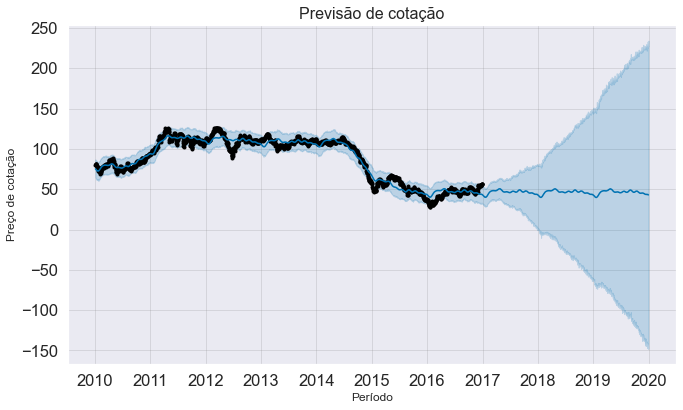

In [56]:
prophet_forecast = prophet_model.make_future_dataframe(periods=1096, freq='D')
prophet_forecast = prophet_model.predict(prophet_forecast)

fig=prophet_model.plot(prophet_forecast)
ax1=fig.gca()
ax1.set_title('Previsão de cotação', fontsize=16)
ax1.set_xlabel('Período', fontsize=12)
ax1.set_ylabel('Preço de cotação', fontsize=12)

In [57]:
prophet_forecast = prophet_forecast[prophet_forecast['ds'] > train_end_date]
prophet_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1788,2017-01-01,46.522636,32.271853,54.417461,46.522636,46.522636,-3.394820,-3.394820,-3.394820,-0.006009,-0.006009,-0.006009,-3.388811,-3.388811,-3.388811,0.0,0.0,0.0,43.127816
1789,2017-01-02,46.522401,31.804644,53.528329,46.522401,46.522401,-3.689596,-3.689596,-3.689596,-0.140324,-0.140324,-0.140324,-3.549272,-3.549272,-3.549272,0.0,0.0,0.0,42.832805
1790,2017-01-03,46.522166,31.753264,53.856961,46.522166,46.522166,-3.798483,-3.798483,-3.798483,-0.074496,-0.074496,-0.074496,-3.723987,-3.723987,-3.723987,0.0,0.0,0.0,42.723683
1791,2017-01-04,46.521930,31.267200,53.303155,46.521930,46.523158,-3.851718,-3.851718,-3.851718,0.059624,0.059624,0.059624,-3.911342,-3.911342,-3.911342,0.0,0.0,0.0,42.670213
1792,2017-01-05,46.521695,31.252054,53.775329,46.518990,46.529545,-3.991363,-3.991363,-3.991363,0.117985,0.117985,0.117985,-4.109349,-4.109349,-4.109349,0.0,0.0,0.0,42.530332


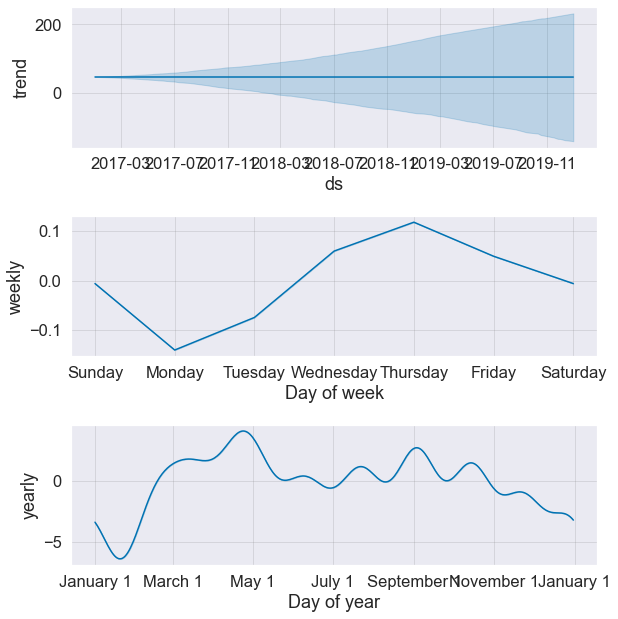

In [58]:
fig=prophet_model.plot_components(prophet_forecast)

In [59]:
prophet_forecast.set_index(prophet_forecast['ds'], inplace=True)
teste_B2_FP.set_index(teste_B2_FP['ds_teste'], inplace=True)
train_B2_FP.set_index(train_B2_FP['ds'], inplace=True)

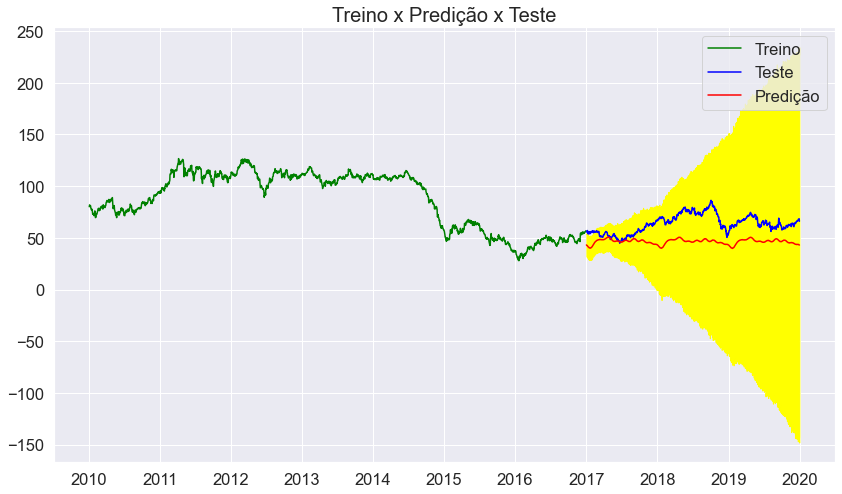

In [60]:
n = train_B2_FP.shape[0]
plt.figure(figsize=(14,8))
plt.title("Treino x Predição x Teste")
plt.plot(train_B2_FP['y'], 'green', label='Treino')
plt.plot(teste_B2_FP['y_teste'], 'blue', label='Teste')
plt.plot(prophet_forecast['yhat'], 'red', label='Predição')
plt.fill_between(prophet_forecast.index, prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='yellow')
plt.legend()
plt.grid(True)

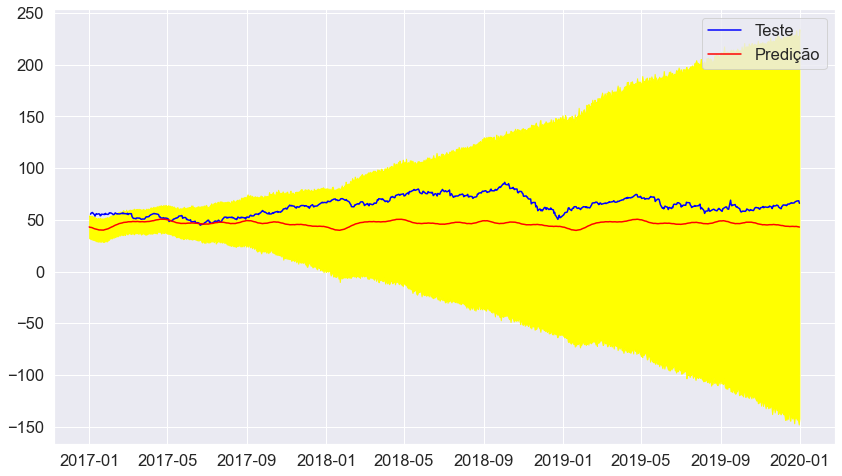

In [61]:
plt.figure(figsize=(14,8))
plt.plot(teste_B2_FP['y_teste'], 'blue', label='Teste')
plt.plot(prophet_forecast['yhat'], 'red', label='Predição')
plt.fill_between(prophet_forecast.index, prophet_forecast['yhat_lower'], prophet_forecast['yhat_upper'], color='yellow')
plt.legend()
plt.grid(True)

In [63]:
pf = prophet_forecast.copy()
tb2 = teste_B2_FP.copy()

pf.rename(columns= {'ds': 'data'}, inplace=True)
tb2.rename(columns= {'ds_teste': 'data'}, inplace=True)

pftb2 = pd.merge(pf,tb2,how='inner', on=['data'],suffixes=('_P', '_T'))
pftb2

,data,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y_teste
0,2017-01-03,46.522166,31.753264,53.856961,46.522166,46.522166,-3.798483,-3.798483,-3.798483,-0.074496,-0.074496,-0.074496,-3.723987,-3.723987,-3.723987,0.0,0.0,0.0,42.723683,55.47
1,2017-01-04,46.521930,31.267200,53.303155,46.521930,46.523158,-3.851718,-3.851718,-3.851718,0.059624,0.059624,0.059624,-3.911342,-3.911342,-3.911342,0.0,0.0,0.0,42.670213,56.46
2,2017-01-05,46.521695,31.252054,53.775329,46.518990,46.529545,-3.991363,-3.991363,-3.991363,0.117985,0.117985,0.117985,-4.109349,-4.109349,-4.109349,0.0,0.0,0.0,42.530332,56.89
3,2017-01-06,46.521460,30.806468,52.818402,46.500924,46.541872,-4.266456,-4.266456,-4.266456,0.049228,0.049228,0.049228,-4.315684,-4.315684,-4.315684,0.0,0.0,0.0,42.255004,57.10
4,2017-01-09,46.520755,30.199963,53.182456,46.422887,46.607116,-5.097600,-5.097600,-5.097600,-0.140324,-0.140324,-0.140324,-4.957276,-4.957276,-4.957276,0.0,0.0,0.0,41.423155,54.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
768,2019-12-24,46.267069,-140.691328,229.004072,-139.839156,230.808042,-2.731992,-2.731992,-2.731992,-0.074496,-0.074496,-0.074496,-2.657496,-2.657496,-2.657496,0.0,0.0,0.0,43.535078,67.20
769,2019-12-26,46.266599,-140.823405,233.369853,-140.121356,231.242182,-2.607993,-2.607993,-2.607993,0.117985,0.117985,0.117985,-2.725979,-2.725979,-2.725979,0.0,0.0,0.0,43.658606,67.92
770,2019-12-27,46.266364,-143.319539,227.894682,-140.260581,231.459252,-2.729845,-2.729845,-2.729845,0.049228,0.049228,0.049228,-2.779073,-2.779073,-2.779073,0.0,0.0,0.0,43.536519,68.16
771,2019-12-30,46.265659,-148.020037,227.181423,-140.970103,232.110462,-3.169816,-3.169816,-3.169816,-0.140324,-0.140324,-0.140324,-3.029493,-3.029493,-3.029493,0.0,0.0,0.0,43.095843,68.44


In [64]:
#Cálculo do erro
print('MAE: ', mean_absolute_error(pftb2['y_teste'],pftb2['yhat']))
print('MSE: ', mean_squared_error(pftb2['y_teste'],pftb2['yhat']))
print('RMSE: ', np.sqrt(mean_squared_error(pftb2['y_teste'],pftb2['yhat'])))

MAE:  17.145523353934433
MSE:  373.3109475977907
RMSE:  19.321256366959958


# SKTIME

In [65]:
pip install sktime

Note: you may need to restart the kernel to use updated packages.


In [66]:
from sktime.forecasting.arima import ARIMA, AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import (
    EnsembleForecaster,
    ReducedRegressionForecaster,
    TransformedTargetForecaster,
)
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.performance_metrics.forecasting import sMAPE, smape_loss
from sktime.transformations.series.detrend import Deseasonalizer, Detrender
from sktime.utils.plotting import plot_series

%matplotlib inline

In [135]:
train_B3=train_B2
teste_B3=teste_B2

y_trainSK=train_B3
y_testSK=teste_B3


In [136]:
y_testSK

,Abertura_B,Último_B,Máxima_B,Data,Vol._B,Mínima_B
data,,,,,,
2019-12-31,66.65,66.00,66.93,2019-12-31,17101000.0,65.63
2019-12-30,68.20,68.44,68.99,2019-12-30,2942000.0,68.16
2019-12-27,67.91,68.16,68.33,2019-12-27,11222000.0,67.57
2019-12-26,67.27,67.92,67.99,2019-12-26,6982000.0,67.22
2019-12-24,66.44,67.20,67.26,2019-12-24,10494000.0,66.36
...,...,...,...,...,...,...
2017-01-09,56.81,54.94,57.00,2017-01-09,26639000.0,54.74
2017-01-06,56.88,57.10,57.47,2017-01-06,23487000.0,56.28
2017-01-05,56.35,56.89,57.35,2017-01-05,26961000.0,56.01


In [137]:
y_trainSK=y_trainSK.drop(columns=["Máxima_B", "Abertura_B", "Mínima_B", "Vol._B"])
y_testSK=y_testSK.drop(columns=["Máxima_B", "Abertura_B", "Mínima_B", "Vol._B"])

In [138]:
y_trainSK

,Último_B,Data
data,,
2016-12-30,56.82,2016-12-30
2016-12-29,56.14,2016-12-29
2016-12-28,56.22,2016-12-28
2016-12-27,56.09,2016-12-27
2016-12-23,55.16,2016-12-23
...,...,...
2010-01-08,81.37,2010-01-08
2010-01-07,81.51,2010-01-07
2010-01-06,81.89,2010-01-06


In [139]:
y_trainI = y_trainSK.sort_values(by='Data')
y_trainI

,Último_B,Data
data,,
2010-01-04,80.12,2010-01-04
2010-01-05,80.59,2010-01-05
2010-01-06,81.89,2010-01-06
2010-01-07,81.51,2010-01-07
2010-01-08,81.37,2010-01-08
...,...,...
2016-12-23,55.16,2016-12-23
2016-12-27,56.09,2016-12-27
2016-12-28,56.22,2016-12-28


In [140]:
y_testI = y_testSK.sort_values(by='Data')
y_testI

,Último_B,Data
data,,
2017-01-03,55.47,2017-01-03
2017-01-04,56.46,2017-01-04
2017-01-05,56.89,2017-01-05
2017-01-06,57.10,2017-01-06
2017-01-09,54.94,2017-01-09
...,...,...
2019-12-24,67.20,2019-12-24
2019-12-26,67.92,2019-12-26
2019-12-27,68.16,2019-12-27


In [141]:
brent3 = brent2
brent3=brent3.drop(columns=["Máxima_B", "Abertura_B", "Mínima_B", "Vol._B"])
brent3I = brent3.sort_values(by='Data')
brent3I=brent3I.drop(columns=["Data"])
y = brent3I['Último_B']
y

data
2010-01-04    80.12
2010-01-05    80.59
2010-01-06    81.89
2010-01-07    81.51
2010-01-08    81.37
              ...  
2019-12-24    67.20
2019-12-26    67.92
2019-12-27    68.16
2019-12-30    68.44
2019-12-31    66.00
Name: Último_B, Length: 2560, dtype: float64

In [142]:
y.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='data', length=2560, freq=None)

In [143]:
y

data
2010-01-04    80.12
2010-01-05    80.59
2010-01-06    81.89
2010-01-07    81.51
2010-01-08    81.37
              ...  
2019-12-24    67.20
2019-12-26    67.92
2019-12-27    68.16
2019-12-30    68.44
2019-12-31    66.00
Name: Último_B, Length: 2560, dtype: float64

In [144]:
y=y.resample('d').mean()

In [145]:
y

data
2010-01-04    80.12
2010-01-05    80.59
2010-01-06    81.89
2010-01-07    81.51
2010-01-08    81.37
              ...  
2019-12-27    68.16
2019-12-28      NaN
2019-12-29      NaN
2019-12-30    68.44
2019-12-31    66.00
Freq: D, Name: Último_B, Length: 3649, dtype: float64

2876 773


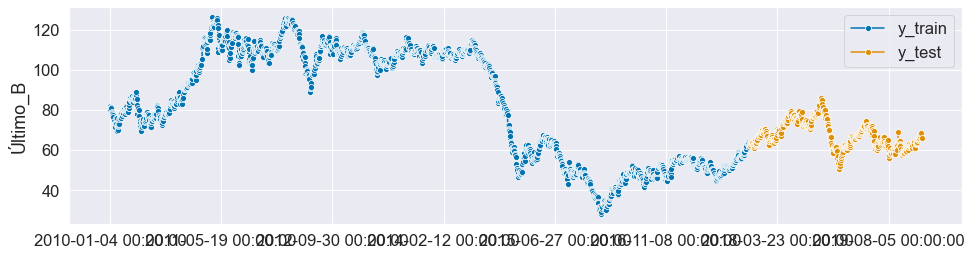

In [146]:
y_trainSK, y_testSK = temporal_train_test_split(y, test_size=773)
plot_series(y_trainSK, y_testSK, labels=["y_train", "y_test"])
print(y_trainSK.shape[0], y_testSK.shape[0])

In [147]:
fh = np.arange(len(y_testSK)) + 1
fh

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [148]:
fh = ForecastingHorizon(y_testSK.index, is_relative=False)
fh


ForecastingHorizon(['2017-11-19', '2017-11-20', '2017-11-21', '2017-11-22',
               '2017-11-23', '2017-11-24', '2017-11-25', '2017-11-26',
               '2017-11-27', '2017-11-28',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='data', length=773, freq='D', is_relative=False)

In [149]:
y.isnull().sum()

1089

In [170]:
y_mediana = y.rolling(5).mean().shift(-5).round(0)
y.fillna(y_mediana, inplace=True)

In [171]:
y.isnull().sum()

0

In [175]:
y_train_mediana = y.rolling(5).mean().shift(-5).round(0)
y_trainSK.fillna(y_train_mediana, inplace=True)

y_test_mediana = y.rolling(5).mean().shift(-5).round(0)
y_testSK.fillna(y_test_mediana, inplace=True)

In [176]:
y_trainSK.isnull().sum()


0

In [177]:
y_testSK.isnull().sum()

0

0.09236973081303312

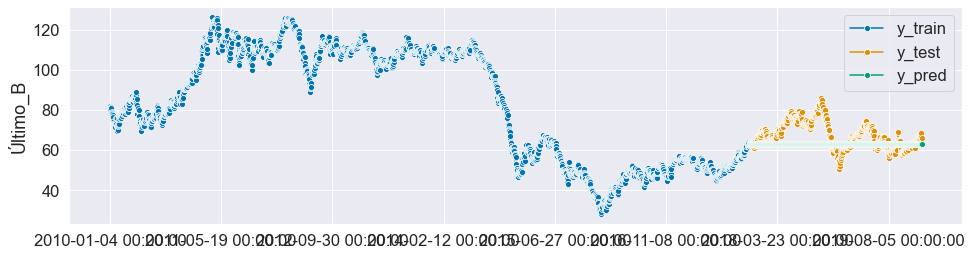

In [178]:
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_trainSK)
y_pred = forecaster.predict(fh)
plot_series(y_trainSK, y_testSK, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_testSK)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Último_B'>)

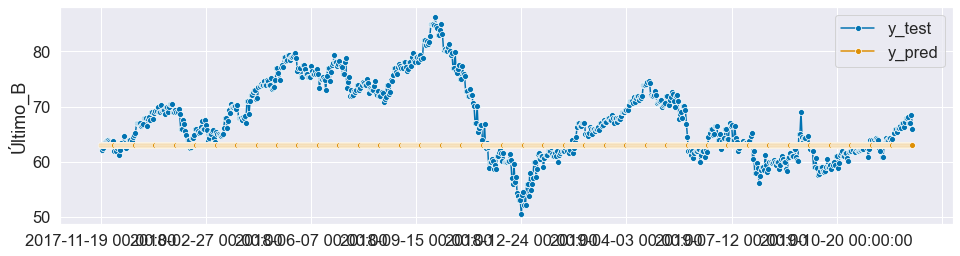

In [179]:
plot_series(y_testSK, y_pred, labels=["y_test", "y_pred"])

In [181]:
print('MAE: ', mean_absolute_error(y_testSK,y_pred))
print('MSE: ', mean_squared_error(y_testSK,y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_testSK,y_pred)))

MAE:  6.2411254851228986
MSE:  66.676482923674
RMSE:  8.165566907672364


0.0951743349663283

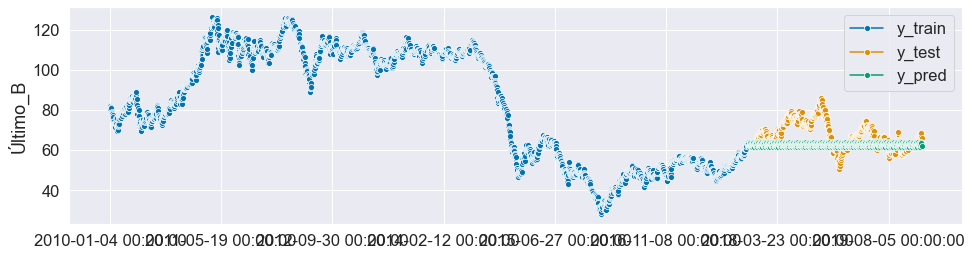

In [182]:
forecaster = NaiveForecaster(strategy="last", sp=12)
forecaster.fit(y_trainSK)
y_pred = forecaster.predict(fh)
plot_series(y_trainSK, y_testSK, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_testSK)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Último_B'>)

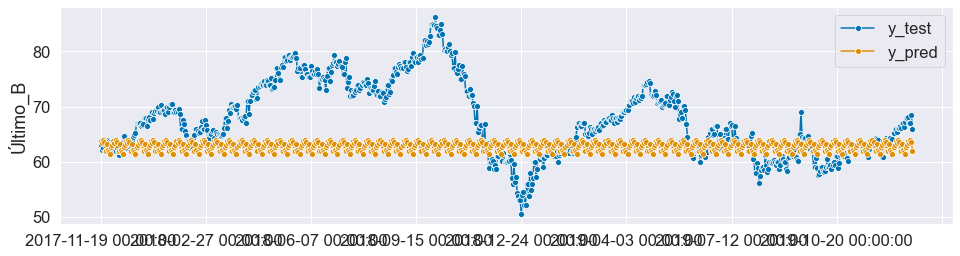

In [183]:
plot_series(y_testSK, y_pred, labels=[ "y_test", "y_pred"])

0.09332332551947344

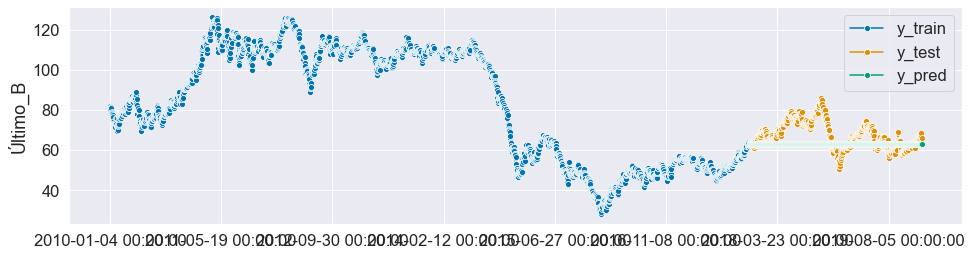

In [184]:
from sktime.forecasting.ets import AutoETS

forecaster = AutoETS(auto=True, sp=12, n_jobs=-1)
forecaster.fit(y_trainSK)
y_pred = forecaster.predict(fh)
plot_series(y_trainSK, y_testSK, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_testSK, y_pred)

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Último_B'>)

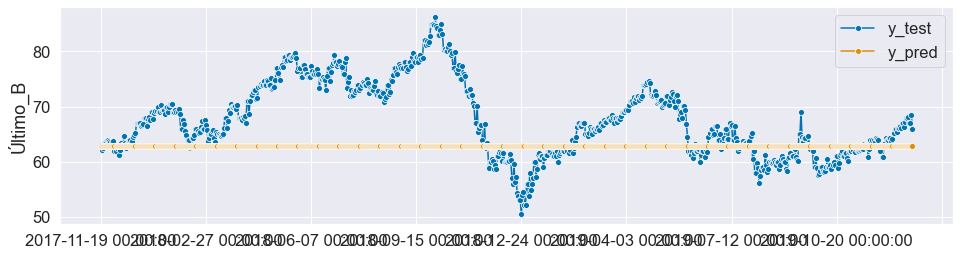

In [185]:
plot_series(y_testSK, y_pred, labels=[ "y_test", "y_pred"])

In [186]:
print('MAE: ', mean_absolute_error(y_testSK,y_pred))
print('MSE: ', mean_squared_error(y_testSK,y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_testSK,y_pred)))

MAE:  6.3015513938898815
MSE:  67.97582616714709
RMSE:  8.244745367029056


In [187]:
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_trainSK)
alpha = 0.05  # 95% prediction intervals
y_pred, pred_ints = forecaster.predict(fh, return_pred_int=True, alpha=alpha)
smape_loss(y_testSK, y_pred)

0.14674560330930167

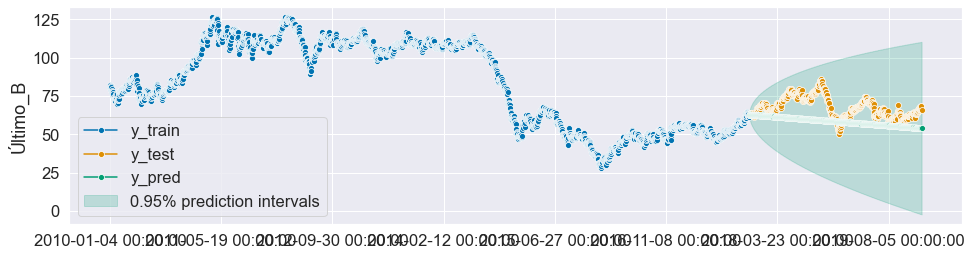

In [188]:
fig, ax = plot_series(y_trainSK, y_testSK, y_pred, labels=["y_train", "y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% prediction intervals",
)
ax.legend();

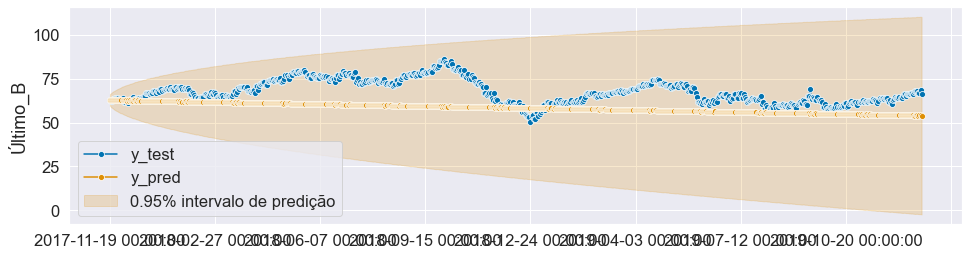

In [189]:
fig, ax = plot_series(y_testSK, y_pred, labels=["y_test", "y_pred"])
ax.fill_between(
    ax.get_lines()[-1].get_xdata(),
    pred_ints["lower"],
    pred_ints["upper"],
    alpha=0.2,
    color=ax.get_lines()[-1].get_c(),
    label=f"{1 - alpha}% intervalo de predição",
)
ax.legend();

In [190]:
print('MAE: ', mean_absolute_error(y_testSK,y_pred))
print('MSE: ', mean_squared_error(y_testSK,y_pred))
print('RMSE: ', np.sqrt(mean_squared_error(y_testSK,y_pred)))

MAE:  9.488035578112644
MSE:  123.48841447144301
RMSE:  11.112534115648105


# ARIMA

In [192]:
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=15,6

In [193]:
from pmdarima.arima import auto_arima

In [194]:
z= y_trainI.copy()
z=z.drop(columns=["Data"])
z

,Último_B
data,
2010-01-04,80.12
2010-01-05,80.59
2010-01-06,81.89
2010-01-07,81.51
2010-01-08,81.37
...,...
2016-12-23,55.16
2016-12-27,56.09
2016-12-28,56.22


In [195]:
stepwise_model=auto_arima(z, start_p=1, start_q=1, max_p=6, max_q=6, m=12, start_P=0, seasonal=False,d=1, D=1, trace=True, error_action='ignore', supress_warnings=True, stepwise=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=6378.379, Time=1.36 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=6378.085, Time=0.47 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=6378.694, Time=0.56 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=6380.694, Time=0.73 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=6381.979, Time=0.75 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=6383.962, Time=1.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=6378.218, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=6379.239, Time=1.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=6380.695, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=6381.425, Time=3.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=6383.988, Time=1.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=6378.652, Time=0.61 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=6380.642, Time=1.85 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6381.539, Time=3.60 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=5.92 sec
 ARIMA(3,1,0)(0

In [196]:
print(stepwise_model.aic())

6378.084892238259


In [197]:
trainarima=z.loc['2010-01-01':'2016-12-31']
testarima=y.loc['2017-01-01':]

In [198]:
stepwise_model.fit(trainarima)

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [199]:
future_forecastarima=stepwise_model.predict(n_periods=1095)

In [200]:
future_forecastarima=pd.DataFrame(future_forecastarima,index=testarima.index, columns=['Predição'])

<AxesSubplot:xlabel='data'>

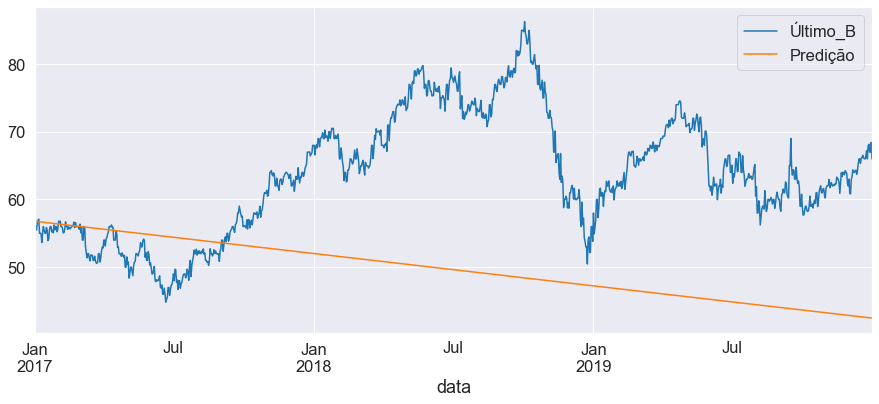

In [201]:
pd.concat([testarima, future_forecastarima], axis=1).plot()

<AxesSubplot:xlabel='data'>

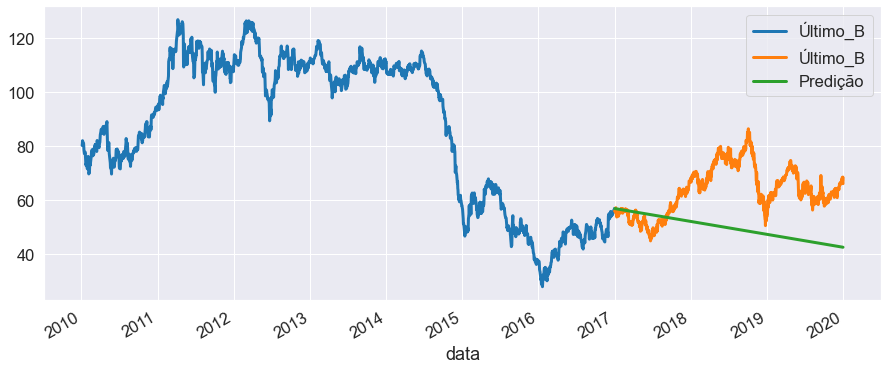

In [202]:
pd.concat([z,testarima, future_forecastarima], axis=1).plot(linewidth=3)

In [203]:
print('MAE: ', mean_absolute_error(testarima, future_forecastarima))
print('MSE: ', mean_squared_error(testarima, future_forecastarima))
print('RMSE: ', np.sqrt(mean_squared_error(testarima, future_forecastarima)))

MAE:  15.283343938135479
MSE:  319.1676593546785
RMSE:  17.86526404379959
